In [1]:
!pip install yfinance torch

  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached frozendict-2.4.6-cp39-cp39-win_amd64.whl.metadata (23 kB)
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     --- ------------------------------------ 0.3/3.0 MB ? eta -:--:--
     ------ --------------------------------- 0.5/3.0 MB 1.3 MB/s eta 0:00:02
     ---------- ----------------------------- 0.8/3.0 MB 1.3 MB/s eta 0:00:02
     ------------- -------------------------- 1.0/3.0 MB 1.3 MB/s eta 0:00:02
     ----------------- ---------------------- 1.3/3.0 MB 1.4 MB/s eta 0:00:02
     -------------------- ------------------- 1.6/3.0 MB 1.4 MB/s eta 0:00:02
     ------------------------ --------------- 1.8/3.0 MB 1.4 MB/s eta 0:00:01
     --------------------------- ------------ 2.1/3.0 MB 1.4 MB/s eta 0:00:01
     ------------------------------- -------- 2.4/3.0 MB 1.4 MB/s eta 0:00:01
     -------------------------------------- - 2.9/3.0 MB 1.4 MB/s eta 0:00:01
     --------

In [2]:
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt

# Fetch data
ticker = "AAPL"
data = yf.download(ticker, start="2020-01-01", end="2023-01-01", interval="1d")

# Preprocess data
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data = data.pct_change().dropna()  # Use percent change as features, then drop NaNs

# Convert to PyTorch Tensors
window_size = 30
X, y = [], []
for i in range(len(data) - window_size - 1):
    X.append(data.iloc[i:i + window_size].values)

    # Define labels based on Close price comparison for the window
    if data['Close'].iloc[i + window_size].values > data['Close'].iloc[i + window_size - 1].values:
        y.append(2)  # Buy
    elif data['Close'].iloc[i + window_size].values < data['Close'].iloc[i + window_size - 1].values:
        y.append(0)  # Sell
    else:
        y.append(1)  # Hold

# Now convert lists to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# DataLoader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


[*********************100%***********************]  1 of 1 completed
<ipython-input-2-68c8606598ca>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X = torch.tensor(X, dtype=torch.float32)


In [3]:
class StockCNN(nn.Module):
    def __init__(self, kernel_size_conv1=3, kernel_size_conv2=3):
        super(StockCNN, self).__init__()
        self.conv1 = nn.Conv1d(5, 16, kernel_size=kernel_size_conv1)  # Input: 5 channels, Output: 16 channels
        self.conv2 = nn.Conv1d(16, 32, kernel_size=kernel_size_conv2)  # Input: 16 channels, Output: 32 channels
        self.fc1 = nn.Linear(32 * (window_size - (kernel_size_conv1 - 1) -(kernel_size_conv2 - 1)), 64)  # Flattened size after conv
        self.fc2 = nn.Linear(64, 3)  # Output: 3 classes (Buy, Hold, Sell)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Permute to (batch_size, channels, sequence_length) -> [32, 5, 30]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the output from convolution layers
        x = torch.relu(self.fc1(x))
        return self.fc2(x)  # Return logits (raw output) for each class

In [4]:
class StockLSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 3)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])
        return x


In [5]:
class StockGRU(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2):
        super(StockGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 3)

    def forward(self, x):
        _, h_n = self.gru(x)
        x = self.fc(h_n[-1])
        return x


In [6]:
import torch
import torch.nn as nn

class StockCNN_LSTM(nn.Module):
    def __init__(self):
        super(StockCNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(5, 16, kernel_size=3)  # Input: 5 channels, Output: 16 channels
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3)  # Input: 16 channels, Output: 32 channels

        self.lstm = nn.LSTM(input_size=32, hidden_size=64, num_layers=1, batch_first=True)

        self.fc1 = nn.Linear(64, 3)  # Output: 3 classes (Buy, Hold, Sell)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Permute to (batch_size, channels, sequence_length) -> [batch, 5, window_size]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)  # Reshape for LSTM: [batch, seq_length, features]

        x, _ = self.lstm(x)  # Pass through LSTM
        x = x[:, -1, :]  # Take the last time step

        return self.fc1(x)  # Return logits for each class

In [7]:
def train_model(model, dataloader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


In [8]:
# Choose model
cnn_model = StockCNN()  # Replace with StockLSTM(), StockGRU(), etc.
train_model(cnn_model, dataloader)

Epoch [1/10], Loss: 0.7102
Epoch [2/10], Loss: 0.6944
Epoch [3/10], Loss: 0.7150
Epoch [4/10], Loss: 0.6680
Epoch [5/10], Loss: 0.7169
Epoch [6/10], Loss: 0.6769
Epoch [7/10], Loss: 0.7211
Epoch [8/10], Loss: 0.7459
Epoch [9/10], Loss: 0.6681
Epoch [10/10], Loss: 0.6707


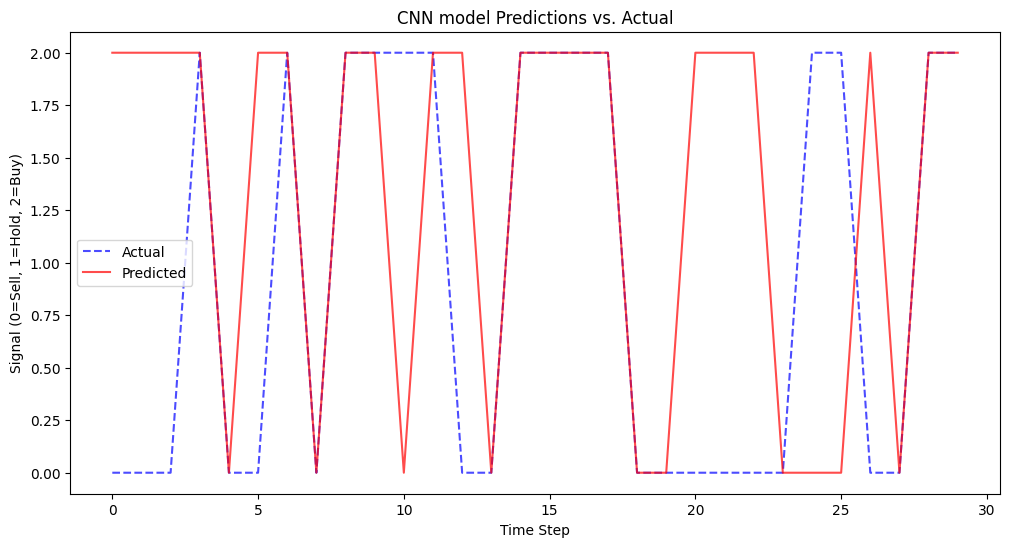

In [9]:
title="CNN model Predictions vs. Actual"
cnn_model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for inputs, targets in dataloader:
        outputs = cnn_model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.numpy())
        all_targets.extend(targets.numpy())

# Plot actual vs predicted labels
plt.figure(figsize=(12, 6))
plt.plot(all_targets[-30:], label='Actual', color='blue', linestyle='--', alpha=0.7)
plt.plot(all_predictions[-30:], label='Predicted', color='red', alpha=0.7)
plt.title(title)
plt.xlabel("Time Step")
plt.ylabel("Signal (0=Sell, 1=Hold, 2=Buy)")
plt.legend()
plt.show()

In [10]:
lstm_model = StockLSTM()  # Replace with StockLSTM(), StockGRU(), etc.
train_model(lstm_model, dataloader)


Epoch [1/10], Loss: 0.7622
Epoch [2/10], Loss: 0.6987
Epoch [3/10], Loss: 0.6915
Epoch [4/10], Loss: 0.6955
Epoch [5/10], Loss: 0.7762
Epoch [6/10], Loss: 0.6967
Epoch [7/10], Loss: 0.6903
Epoch [8/10], Loss: 0.6958
Epoch [9/10], Loss: 0.6809
Epoch [10/10], Loss: 0.7004


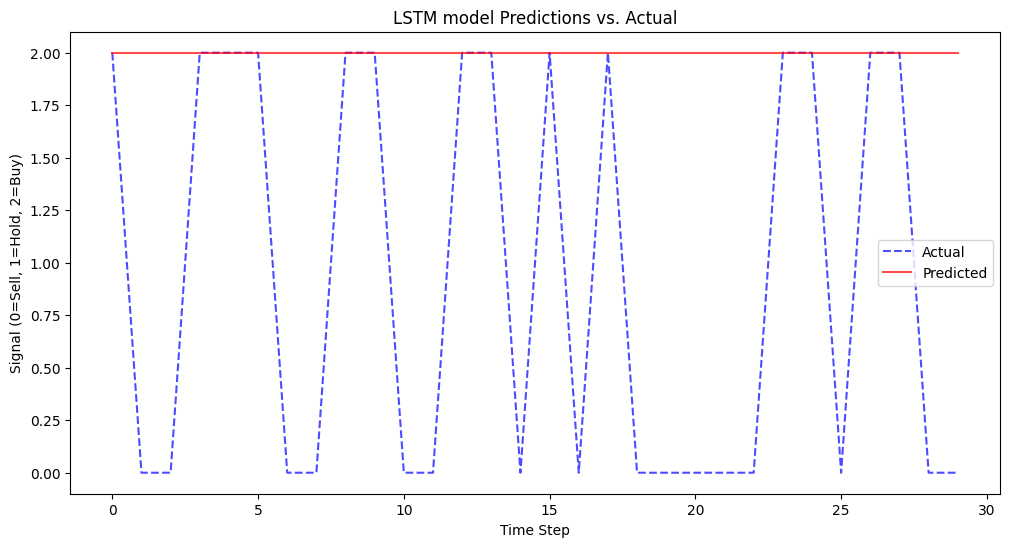

In [11]:
title="LSTM model Predictions vs. Actual"
lstm_model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for inputs, targets in dataloader:
        outputs = lstm_model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.numpy())
        all_targets.extend(targets.numpy())

# Plot actual vs predicted labels
plt.figure(figsize=(12, 6))
plt.plot(all_targets[-30:], label='Actual', color='blue', linestyle='--', alpha=0.7)
plt.plot(all_predictions[-30:], label='Predicted', color='red', alpha=0.7)
plt.title(title)
plt.xlabel("Time Step")
plt.ylabel("Signal (0=Sell, 1=Hold, 2=Buy)")
plt.legend()
plt.show()

In [12]:
gru_model = StockGRU()  # Replace with StockLSTM(), StockGRU(), etc.
train_model(gru_model, dataloader)

Epoch [1/10], Loss: 0.7430
Epoch [2/10], Loss: 0.7283
Epoch [3/10], Loss: 0.8065
Epoch [4/10], Loss: 0.6889
Epoch [5/10], Loss: 0.6917
Epoch [6/10], Loss: 0.6979
Epoch [7/10], Loss: 0.6942
Epoch [8/10], Loss: 0.6410
Epoch [9/10], Loss: 0.6851
Epoch [10/10], Loss: 0.6944


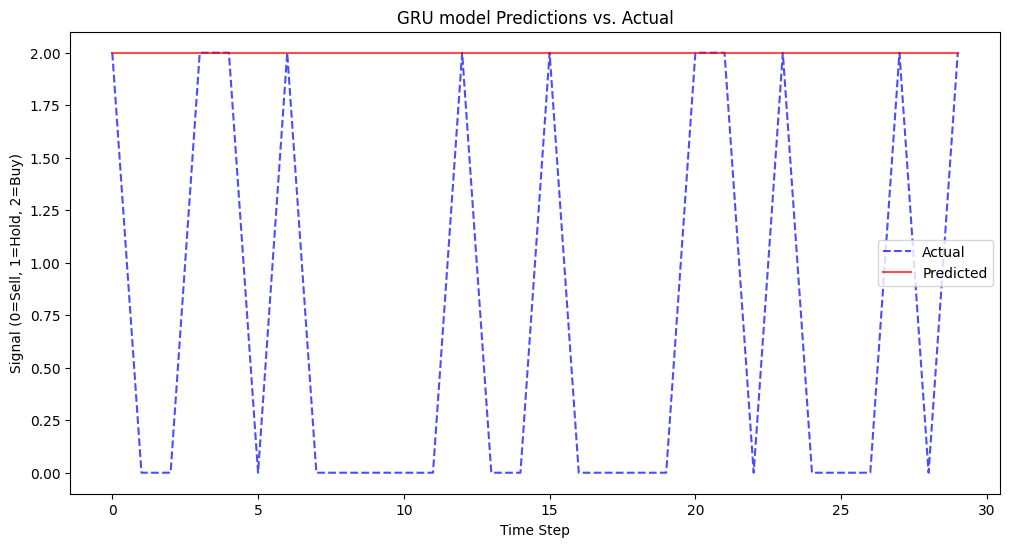

In [13]:
title="GRU model Predictions vs. Actual"
gru_model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for inputs, targets in dataloader:
        outputs = gru_model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.numpy())
        all_targets.extend(targets.numpy())

# Plot actual vs predicted labels
plt.figure(figsize=(12, 6))
plt.plot(all_targets[-30:], label='Actual', color='blue', linestyle='--', alpha=0.7)
plt.plot(all_predictions[-30:], label='Predicted', color='red', alpha=0.7)
plt.title(title)
plt.xlabel("Time Step")
plt.ylabel("Signal (0=Sell, 1=Hold, 2=Buy)")
plt.legend()
plt.show()

In [14]:
cnn_lstm_model = StockCNN_LSTM()  # Replace with StockLSTM(), StockGRU(), etc.
train_model(cnn_lstm_model, dataloader)

Epoch [1/10], Loss: 0.7379
Epoch [2/10], Loss: 0.6615
Epoch [3/10], Loss: 0.7148
Epoch [4/10], Loss: 0.6980
Epoch [5/10], Loss: 0.7000
Epoch [6/10], Loss: 0.6974
Epoch [7/10], Loss: 0.6426
Epoch [8/10], Loss: 0.6951
Epoch [9/10], Loss: 0.6900
Epoch [10/10], Loss: 0.7013


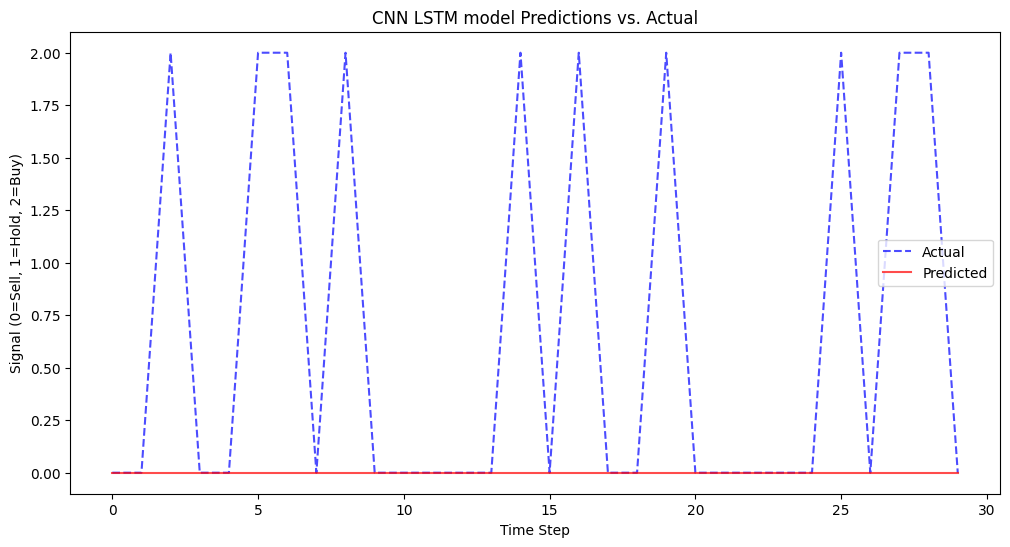

In [15]:
title="CNN LSTM model Predictions vs. Actual"
cnn_lstm_model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for inputs, targets in dataloader:
        outputs = cnn_lstm_model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.numpy())
        all_targets.extend(targets.numpy())

# Plot actual vs predicted labels
plt.figure(figsize=(12, 6))
plt.plot(all_targets[-30:], label='Actual', color='blue', linestyle='--', alpha=0.7)
plt.plot(all_predictions[-30:], label='Predicted', color='red', alpha=0.7)
plt.title(title)
plt.xlabel("Time Step")
plt.ylabel("Signal (0=Sell, 1=Hold, 2=Buy)")
plt.legend()
plt.show()